In [2]:
import torch
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

1.8.2+cu111


In [4]:
torch.cuda.is_available()

True

The data course is from kaggle youtube  statistics:
https://www.kaggle.com/code/elem3ntary/predicting-comment-sentiment/data

The code is from :https://sebastianraschka.com/blog/2021/dl-course.html

Comment Sentiment:
0 represents a negative sentiment
1 and 2 represent neutral

In [5]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 3

In [6]:
print(DEVICE)

cuda


<AxesSubplot: xlabel='Sentiment'>

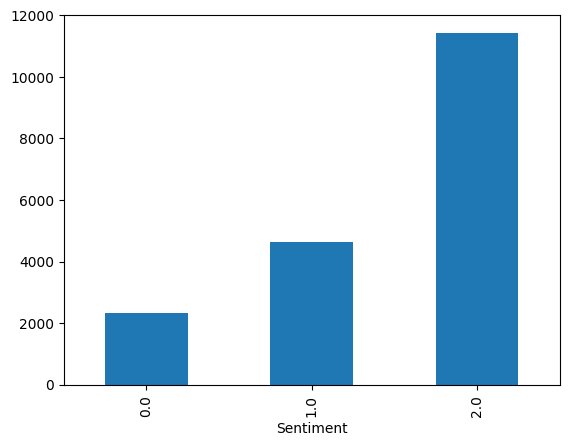

In [7]:
# read the data
comment =  pd.read_csv('comments.csv')
comment.groupby('Sentiment').count()['Comment'].plot.bar()


In [8]:
#look at data
comment.head()

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


In [9]:
comment.iloc[3,2]

'Whenever I go to a place that doesn’t take Apple Pay (doesn’t happen too often), it’s such a drag. Between ‘contactless Covid’ habits and my getting the Apple Card, I’ve gotten so used to Apple Pay that I get seriously annoyed when a store doesn’t take it. It feels like a shock, it’s crazy how quickly it took over my shopping routine! I’ve officially been brainwashed by Apple because now it feels so inconvenient to even carry a physical card in my pocket.'

In [10]:
# look the data
comment.describe()

,Unnamed: 0,Likes,Sentiment
count,18409.000000,18409.000000,18409.000000
mean,9204.000000,1040.019447,1.493998
std,5314.364888,10651.366148,0.709928
min,0.000000,0.000000,0.000000
25%,4602.000000,5.000000,1.000000
50%,9204.000000,29.000000,2.000000
75%,13806.000000,190.000000,2.000000
max,18408.000000,891372.000000,2.000000


In [11]:
#do not have null data
comment.isnull().count()

Unnamed: 0    18409
Video ID      18409
Comment       18409
Likes         18409
Sentiment     18409
dtype: int64

In [12]:
#drop the other columns, and change 1 and 2 in sentiment to 1
comment_data = comment.drop(columns = ['Unnamed: 0', 'Video ID', 'Likes'])
comment_data.groupby('Sentiment').count()

,Comment
Sentiment,
0.0,2338
1.0,4638
2.0,11432


In [13]:
#change column name
comment_data.columns = ['TEXT_COLUMN_NAME', 'LABEL_COLUMN_NAME']

In [14]:
comment_data.to_csv('youtube_data.csv', index=None)
comment_look = pd.read_csv('youtube_data.csv')



Download English vocabulary via:

- `python -m spacy download en_core_web_sm`



In [15]:
# only have legacy in torchtext==0.9
# pip install torchtext==0.9
### Defining the feature processing

TEXT = torchtext.legacy.data.Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm'
)

### Defining the label processing

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)


In [16]:
fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
    path='youtube_data.csv', format='csv',
    skip_header=True, fields=fields)



In [17]:
# separate into train and test set
train_data, test_data = dataset.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')


Num Train: 14727
Num Test: 3682


In [18]:
# separate into train, valid and test set
train_data, valid_data = train_data.split(
    split_ratio=[0.85, 0.15],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')


Num Train: 12518
Num Validation: 2209


In [19]:
print(vars(train_data.examples[0]))


{'TEXT_COLUMN_NAME': ['Definitely', 'trying', 'this', 'tomorrow', 'on', 'my', 'son', '.', 'This', 'cut', 'is', 'detailed', 'with', 'all', 'the', 'instructions', '.', 'Appreciate', 'you', 'sharing', 'this', 'knowledge', ',', 'stay', 'blessed', 'my', 'brother'], 'LABEL_COLUMN_NAME': '2.0'}


## Build Vocabulary

Build the vocabulary based on the top "VOCABULARY_SIZE" words:

In [20]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 20002
Number of classes: 3


- 20,002 not 20,000 because of the `<unk>` and `<pad>` tokens
- PyTorch RNNs can deal with arbitrary lengths due to dynamic graphs, but padding is necessary for padding sequences to the same length in a given minibatch so we can store those in an array

In [21]:
#Look at most common words:
print(TEXT.vocab.freqs.most_common(20))


[('.', 17588), ('the', 13963), (',', 12709), ('I', 10643), ('to', 10043), ('and', 9479), ('a', 8730), ('of', 6448), ('\n', 6438), ('!', 5617), ('is', 5523), ('you', 5371), ('in', 5036), ('it', 4599), ('for', 4536), ('that', 4096), ('this', 3756), ('"', 2630), ('on', 2556), ('my', 2515)]


In [22]:
#Tokens corresponding to the first 10 indices (0, 1, ..., 9):
print(TEXT.vocab.itos[:10]) # itos = integer-to-string



['<unk>', '<pad>', '.', 'the', ',', 'I', 'to', 'and', 'a', 'of']


**Converting a string to an integer:**

In [23]:
print(TEXT.vocab.stoi['the']) # stoi = string-to-integer

3


**Class labels:**

In [24]:
print(LABEL.vocab.stoi)

defaultdict(None, {'2.0': 0, '1.0': 1, '0.0': 2})


**Class label count:**

In [25]:
LABEL.vocab.freqs

Counter({'2.0': 7722, '1.0': 3174, '0.0': 1622})

## Define Data Loaders

In [26]:
train_loader, valid_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size=BATCH_SIZE,
         sort_within_batch=False,
         sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
         device=DEVICE
    )

Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [27]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

Train
Text matrix size: torch.Size([718, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([8, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([6, 128])
Target vector size: torch.Size([128])


## Model

In [28]:
class RNN(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        #self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.fc = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, text):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        output = self.fc(hidden)
        return output

In [29]:
torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Training

In [30]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [31]:
def predict_label(model, data_loader, device):

    with torch.no_grad():
        Y_acctual, Y_preds = [], []
        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            Y_preds.append(predicted_labels.cpu().data.numpy())
            Y_acctual.append(targets.cpu().data.numpy())
    return  np.concatenate(Y_preds), np.concatenate(Y_acctual)

In [32]:
start_time = time.time()

train_accuracy = []
valid_accuracy = []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):

        text = batch_data.TEXT_COLUMN_NAME.to(DEVICE)
        labels = batch_data.LABEL_COLUMN_NAME.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:

            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        train_accuracy.append(float(f'{compute_accuracy(model, train_loader, DEVICE):.2f}'))
        valid_accuracy.append(float(f'{compute_accuracy(model, valid_loader, DEVICE):.2f}'))
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')


Epoch: 001/100 | Batch 000/098 | Loss: 1.1501
Epoch: 001/100 | Batch 050/098 | Loss: 0.8992
training accuracy: 61.85%
valid accuracy: 57.85%
Time elapsed: 0.55 min
Epoch: 002/100 | Batch 000/098 | Loss: 0.8820
Epoch: 002/100 | Batch 050/098 | Loss: 0.9586
training accuracy: 61.87%
valid accuracy: 61.20%
Time elapsed: 0.80 min
Epoch: 003/100 | Batch 000/098 | Loss: 0.8802
Epoch: 003/100 | Batch 050/098 | Loss: 0.9244
training accuracy: 62.01%
valid accuracy: 60.39%
Time elapsed: 1.05 min
Epoch: 004/100 | Batch 000/098 | Loss: 0.9151
Epoch: 004/100 | Batch 050/098 | Loss: 0.8209
training accuracy: 62.01%
valid accuracy: 60.21%
Time elapsed: 1.31 min
Epoch: 005/100 | Batch 000/098 | Loss: 0.8167
Epoch: 005/100 | Batch 050/098 | Loss: 0.9348
training accuracy: 62.09%
valid accuracy: 60.30%
Time elapsed: 1.55 min
Epoch: 006/100 | Batch 000/098 | Loss: 0.9635
Epoch: 006/100 | Batch 050/098 | Loss: 0.8965
training accuracy: 62.05%
valid accuracy: 58.44%
Time elapsed: 1.81 min
Epoch: 007/100 |

In [33]:
import spacy

nlp = spacy.blank("en")

def predict_sentiment(model, sentence):

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(model(tensor), dim=1)
    return prediction[0][0].item()

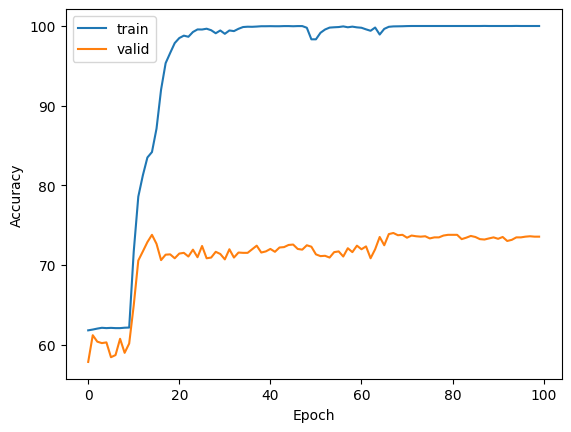

In [34]:
plt.plot(train_accuracy, label = 'train')
plt.plot(valid_accuracy, label = 'valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')

In [35]:
print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")


Probability positive:


0.9998282194137573

In [36]:
print('Probability negative:')
1-predict_sentiment(model, "Whenever I go to a place that doesn’t take Apple Pay (doesn’t happen too often), it’s such a drag. Between ‘contactless Covid’ habits and my getting the Apple Card, I’ve gotten so used to Apple Pay that I get seriously annoyed when a store doesn’t take it. It feels like a shock, it’s crazy how quickly it took over my shopping routine! I’ve officially been brainwashed by Apple because now it feels so inconvenient to even carry a physical card in my pocket")

Probability negative:


0.9795073289424181

In [37]:
predict_label, real_label= predict_label(model, test_loader, DEVICE)
print(predict_label, real_label)

[1 0 0 ... 1 1 2] [1. 0. 1. ... 2. 1. 1.]


In [38]:
#confuion matrix
import seaborn as sns
cf_matrix = confusion_matrix(real_label, predict_label)
cf_matrix

array([[1955,  241,  127],
       [ 232,  502,  171],
       [ 115,  160,  179]], dtype=int64)

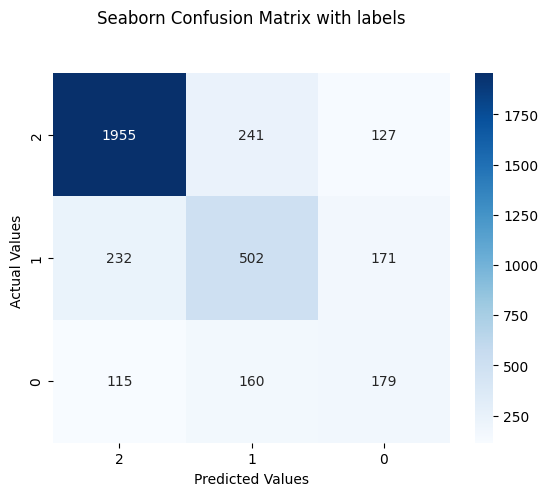

In [39]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = '.20g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['2','1','0'])
ax.yaxis.set_ticklabels(['2','1','0'])

plt.savefig('confusion_matrix.png')
## Display the visualization of the Confusion Matrix.
plt.show()